<a href="https://colab.research.google.com/github/ELPIR0B0/-rbol-de-Decisi-n-para-Clasificaci-n-de-Spam-Ham/blob/main/knn_voter_intention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de intención de voto con KNN (proyecto académico)

_Autor:_ Estudiante de Ingeniería de Datos  
_Fecha:_ 2025-11-12

> Nota personal: intenté que esto se sienta como un cuaderno real de trabajo: comentarios francos, decisiones justificadas y pequeños ajustes sobre la marcha.

In [12]:
!pip install flask pyngrok pandas scikit-learn joblib --quiet


## 1) Importaciones y configuración
Solo uso `pandas`, `sklearn` y `matplotlib` (más `joblib` para guardar el modelo, que viene como dependencia habitual de scikit-learn).

In [3]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
import joblib

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['axes.grid'] = True
RANDOM_STATE = 42
DATASET_PATH = '/content/voter_intentions_3000.csv'
TARGET = 'intended_vote'


## 2) Carga del dataset y EDA básico
Aquí chequeo tipos, nulos, estadísticas y la distribución de clases. Si el archivo no está en la ruta, levanto un error claro para no perder tiempo.

Dimensiones: (3000, 33)

Primeras filas:


,age,gender,education,employment_status,employment_sector,income_bracket,marital_status,household_size,has_children,urbanicity,...,preference_strength,survey_confidence,tv_news_hours,social_media_hours,trust_media,civic_participation,job_tenure_years,primary_choice,secondary_choice,intended_vote
0,19.0,1.0,2.0,5.0,2.0,3.0,4.0,4.0,0.0,1.0,...,0.0,6.0,0.0,3.0,2.0,6.0,27.0,CAND_Frontera,CAND_Halley,Undecided
1,63.0,1.0,4.0,3.0,3.0,0.0,2.0,7.0,0.0,0.0,...,9.0,0.0,2.0,5.0,5.0,6.0,10.0,CAND_Demetra,CAND_Jade,Undecided
2,57.0,1.0,5.0,5.0,2.0,1.0,1.0,2.0,0.0,1.0,...,10.0,2.0,5.0,3.0,9.0,8.0,24.0,CAND_Civico,CAND_Halley,Undecided
3,21.0,1.0,1.0,3.0,2.0,3.0,1.0,5.0,0.0,0.0,...,NaN,6.0,1.0,3.0,0.0,10.0,25.0,CAND_Azon,CAND_Civico,Undecided
4,78.0,0.0,2.0,1.0,1.0,NaN,3.0,7.0,1.0,1.0,...,6.0,7.0,0.0,2.0,8.0,5.0,24.0,CAND_Demetra,CAND_Jade,Undecided



Tipos de datos:
age                    float64
gender                 float64
education              float64
employment_status      float64
employment_sector      float64
income_bracket         float64
marital_status         float64
household_size         float64
has_children           float64
urbanicity             float64
region                 float64
voted_last             float64
party_id_strength      float64
union_member           float64
public_sector          float64
home_owner             float64
small_biz_owner        float64
owns_car               float64
wa_groups              float64
refused_count          float64
attention_check        float64
will_turnout           float64
undecided              float64
preference_strength    float64
survey_confidence      float64
tv_news_hours          float64
social_media_hours     float64
trust_media            float64
civic_participation    float64
job_tenure_years       float64
primary_choice          object
secondary_choice      

,age,gender,education,employment_status,employment_sector,income_bracket,marital_status,household_size,has_children,urbanicity,...,attention_check,will_turnout,undecided,preference_strength,survey_confidence,tv_news_hours,social_media_hours,trust_media,civic_participation,job_tenure_years
count,2846.000000,2845.000000,2844.000000,2840.000000,2848.000000,2852.000000,2857.000000,2838.000000,2836.000000,2847.000000,...,2837.000000,2850.000000,2865.000000,2883.000000,2843.000000,2859.000000,2848.000000,2848.000000,2841.000000,2849.000000
mean,51.036191,0.532162,2.458509,2.475000,2.513343,1.956522,2.015051,3.962650,0.547955,0.992975,...,0.909411,0.604912,0.751134,5.123136,5.041154,2.514166,2.474719,5.039677,4.961281,20.138294
std,19.254336,0.535093,1.717275,1.700778,1.700172,1.418746,1.415495,1.992057,0.497783,0.813160,...,0.287074,0.488955,0.432431,3.151687,3.195825,1.719905,1.704369,3.181022,3.121921,12.023349
min,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,9.000000
50%,51.000000,1.000000,2.000000,2.000000,3.000000,2.000000,2.000000,4.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,5.000000,5.000000,3.000000,2.000000,5.000000,5.000000,20.000000
75%,68.000000,1.000000,4.000000,4.000000,4.000000,3.000000,3.000000,6.000000,1.000000,2.000000,...,1.000000,1.000000,1.000000,8.000000,8.000000,4.000000,4.000000,8.000000,8.000000,31.000000
max,84.000000,2.000000,5.000000,5.000000,5.000000,4.000000,4.000000,7.000000,1.000000,2.000000,...,1.000000,1.000000,1.000000,10.000000,10.000000,5.000000,5.000000,10.000000,10.000000,40.000000



Estadísticos (categóricas):


,primary_choice,secondary_choice,intended_vote
count,3000,2869,3000
unique,10,10,11
top,CAND_Gaia,CAND_Demetra,Undecided
freq,619,350,2245



Distribución de clases de la variable objetivo:


,count
intended_vote,
Undecided,2245
CAND_Gaia,160
CAND_Azon,130
CAND_Demetra,119
CAND_Civico,77
CAND_Electra,68
CAND_Jade,47
CAND_Halley,41
CAND_Icaro,39


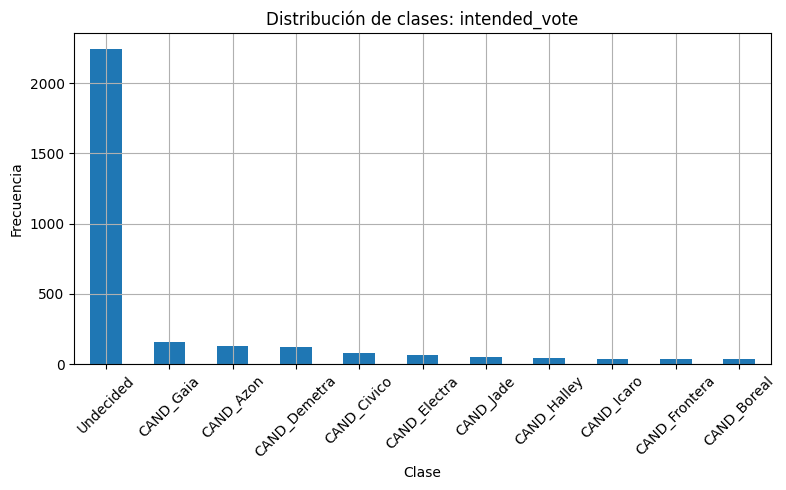

In [4]:
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(
        f"No encontré el archivo en {DATASET_PATH}. Sube 'voter_intentions_3000.csv' a Colab y ajusta DATASET_PATH."
    )

df = pd.read_csv(DATASET_PATH)
print("Dimensiones:", df.shape)
print("\nPrimeras filas:")
display(df.head())

print("\nTipos de datos:")
print(df.dtypes)

print("\nValores nulos por columna:")
print(df.isna().sum())

print("\nEstadísticos (numéricos):")
display(df.describe(include='number'))

print("\nEstadísticos (categóricas):")
display(df.describe(include='object'))

if TARGET not in df.columns:
    raise KeyError(f"No encontré la columna objetivo '{TARGET}'. Verifica el nombre exacto en el CSV.")

print("\nDistribución de clases de la variable objetivo:")
class_counts = df[TARGET].value_counts(dropna=False)
display(class_counts)

ax = class_counts.sort_values(ascending=False).plot(kind='bar', rot=45)
ax.set_title('Distribución de clases: intended_vote')
ax.set_xlabel('Clase')
ax.set_ylabel('Frecuencia')
plt.tight_layout()
plt.show()


## 3) Imputación de valores faltantes
**Decisión:** Para variables numéricas uso **RandomForestRegressor** como imputador basado en modelo (más flexible ante relaciones no lineales que una regresión lineal simple). Para categóricas uso **moda** porque en la práctica es robusto, rápido y evita forzar distancias artificiales entre categorías.

Voy a implementar un transformador de `sklearn` llamado `RFModelImputer` que, por cada variable numérica con faltantes, entrena un bosque aleatorio con las demás columnas para predecir esa variable y luego completa los vacíos. Lo separo así para mantener la lógica dentro del `Pipeline` y no olvidar reproducir el proceso en inferencia.

In [5]:
class RFModelImputer(BaseEstimator, TransformerMixin):
    """
    Imputa columnas numéricas usando RandomForestRegressor por columna.
    - Entrena un modelo por cada columna numérica con valores faltantes.
    - Usa one-hot de categóricas internamente SOLO para la imputación.
    Nota: mantengo el target fuera para evitar fuga de información.
    """
    def __init__(self, target_col='intended_vote', random_state=42, n_estimators=120):
        self.target_col = target_col
        self.random_state = random_state
        self.n_estimators = n_estimators
        self.models_ = {}
        self.feature_columns_ = {}
        self.columns_ = None

    def fit(self, X, y=None):
        df = X.copy()
        if self.target_col in df.columns:
            df = df.drop(columns=[self.target_col])
        num_cols = df.select_dtypes(include=['number']).columns.tolist()
        cat_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

        # One-hot para imputación interna
        df_dum = pd.get_dummies(df, columns=cat_cols, drop_first=True)

        for col in num_cols:
            mask_missing = X[col].isna()
            if mask_missing.any():
                # No usar la columna objetivo de imputación como entrada
                X_all = df_dum.drop(columns=[col] if col in df_dum.columns else [])
                not_na = ~mask_missing
                X_train = X_all.loc[not_na]
                y_train = X.loc[not_na, col]
                if len(y_train) == 0:
                    continue
                model = RandomForestRegressor(
                    n_estimators=self.n_estimators,
                    random_state=self.random_state,
                    n_jobs=-1
                )
                model.fit(X_train, y_train)
                self.models_[col] = model
                self.feature_columns_[col] = X_train.columns
        self.columns_ = X.columns
        return self

    def transform(self, X):
        df = X.copy()
        if len(self.models_) == 0:
            return df
        base = df.drop(columns=[self.target_col], errors='ignore')
        cat_cols = base.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
        df_dum = pd.get_dummies(base, columns=cat_cols, drop_first=True)

        for col, model in self.models_.items():
            feat_cols = self.feature_columns_[col]
            X_aligned = df_dum.reindex(columns=feat_cols, fill_value=0)
            mask_missing = df[col].isna()
            if mask_missing.any():
                df.loc[mask_missing, col] = model.predict(X_aligned.loc[mask_missing])
        return df


## 4) Selección de columnas, split y `Pipeline`
Aquí detecto dinámicamente columnas numéricas y categóricas. Luego armo un `Pipeline` que:
1. Imputa numéricos con `RFModelImputer` (mi transformador casero).
2. Aplica `ColumnTransformer`:
   - Categóricas → `SimpleImputer(most_frequent)` + `OneHotEncoder(handle_unknown='ignore')`.
   - Numéricas → `StandardScaler` (prefiero `StandardScaler` sobre `MinMax` porque KNN con distancia euclídea es sensible a escala y aquí no necesito comprimir a [0,1]).
3. Clasificador KNN.

In [6]:
# Separo X, y
y = df[TARGET]
X = df.drop(columns=[TARGET])

# Detecto tipos
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)

# Divido 80/20 estratificado para mantener proporción de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[
        ('cat', cat_pipe, cat_cols),
        ('num', num_pipe, num_cols)
    ]
)

def build_pipeline(k=11, weights='distance', metric='minkowski'):
    """Arma el pipeline completo para un KNN dado.
    - n_neighbors (k): número de vecinos, ajustaremos por CV.
    - weights: 'uniform' (todos igual) o 'distance' (más peso a vecinos cercanos).
    - metric: distancia; 'minkowski' con p=2 es euclídea.
    """
    knn = KNeighborsClassifier(n_neighbors=k, weights=weights, metric=metric)
    pipe = Pipeline([
        ('rf_imputer', RFModelImputer(target_col=TARGET, random_state=RANDOM_STATE)),
        ('prep', preprocess),
        ('knn', knn)
    ])
    return pipe


Numéricas: ['age', 'gender', 'education', 'employment_status', 'employment_sector', 'income_bracket', 'marital_status', 'household_size', 'has_children', 'urbanicity', 'region', 'voted_last', 'party_id_strength', 'union_member', 'public_sector', 'home_owner', 'small_biz_owner', 'owns_car', 'wa_groups', 'refused_count', 'attention_check', 'will_turnout', 'undecided', 'preference_strength', 'survey_confidence', 'tv_news_hours', 'social_media_hours', 'trust_media', 'civic_participation', 'job_tenure_years']
Categóricas: ['primary_choice', 'secondary_choice']


## 5) Búsqueda del mejor **k** con validación cruzada
Voy a probar `k` impares para evitar empates (1 a 31). Uso `StratifiedKFold` para mantener la distribución de clases en cada pliegue. Gráfico el **error** promedio (1 - accuracy) vs `k`.

k=1: accuracy CV promedio = 0.7421 +/- 0.0068
k=3: accuracy CV promedio = 0.7762 +/- 0.0028
k=5: accuracy CV promedio = 0.7771 +/- 0.0054
k=7: accuracy CV promedio = 0.7688 +/- 0.0040
k=9: accuracy CV promedio = 0.7650 +/- 0.0033
k=11: accuracy CV promedio = 0.7596 +/- 0.0021
k=13: accuracy CV promedio = 0.7588 +/- 0.0024
k=15: accuracy CV promedio = 0.7554 +/- 0.0010
k=17: accuracy CV promedio = 0.7542 +/- 0.0013
k=19: accuracy CV promedio = 0.7517 +/- 0.0028
k=21: accuracy CV promedio = 0.7500 +/- 0.0019
k=23: accuracy CV promedio = 0.7500 +/- 0.0019
k=25: accuracy CV promedio = 0.7492 +/- 0.0017
k=27: accuracy CV promedio = 0.7492 +/- 0.0017
k=29: accuracy CV promedio = 0.7488 +/- 0.0017
k=31: accuracy CV promedio = 0.7492 +/- 0.0017


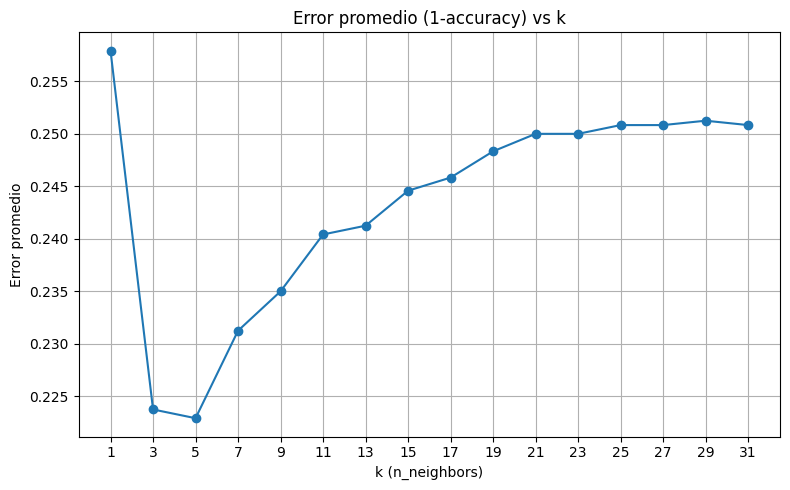

Mejor k según CV: 5


In [7]:
k_values = list(range(1, 32, 2))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
mean_scores = []

for k in k_values:
    pipe = build_pipeline(k=k, weights='distance', metric='minkowski')
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    mean_scores.append(scores.mean())
    print(f"k={k}: accuracy CV promedio = {scores.mean():.4f} +/- {scores.std():.4f}")

errors = [1 - s for s in mean_scores]
plt.plot(k_values, errors, marker='o')
plt.title('Error promedio (1-accuracy) vs k')
plt.xlabel('k (n_neighbors)')
plt.ylabel('Error promedio')
plt.xticks(k_values)
plt.tight_layout()
plt.show()

best_idx = int(errors.index(min(errors)))
best_k = k_values[best_idx]
print(f"Mejor k según CV: {best_k}")


## 6) Entrenamiento final y evaluación en test
Ahora re-entreno con el `k` óptimo y evalúo en el 20% de prueba. Reporto `accuracy`, `classification_report` y la `confusion_matrix` (con gráfico simple).

Accuracy en test: 0.7767

Classification report (por clase):
               precision    recall  f1-score   support

    CAND_Azon     0.3571    0.1923    0.2500        26
  CAND_Boreal     0.0000    0.0000    0.0000         7
  CAND_Civico     0.2000    0.1333    0.1600        15
 CAND_Demetra     0.3529    0.2500    0.2927        24
 CAND_Electra     0.0000    0.0000    0.0000        14
CAND_Frontera     0.2500    0.1250    0.1667         8
    CAND_Gaia     0.1667    0.0625    0.0909        32
  CAND_Halley     0.0000    0.0000    0.0000         8
   CAND_Icaro     0.0000    0.0000    0.0000         8
    CAND_Jade     0.2000    0.1111    0.1429         9
    Undecided     0.8456    1.0000    0.9163       449

     accuracy                         0.7767       600
    macro avg     0.2157    0.1704    0.1836       600
 weighted avg     0.6826    0.7767    0.7215       600

Matriz de confusión (raw counts):
 [[  5   0   0   1   0   1   2   0   0   1  16]
 [  0   0   0   2   1   0   0

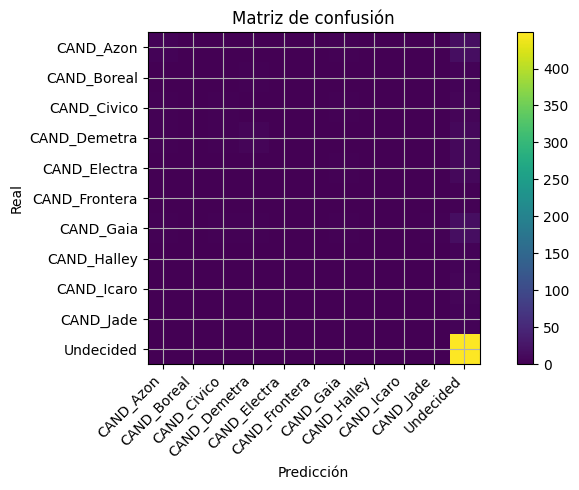

In [8]:
final_pipe = build_pipeline(k=best_k, weights='distance', metric='minkowski')
final_pipe.fit(X_train, y_train)
y_pred = final_pipe.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy en test: {acc:.4f}")

print("\nClassification report (por clase):")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=sorted(y_test.unique()))
print("Matriz de confusión (raw counts):\n", cm)

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest')
ax.set_title('Matriz de confusión')
ax.set_xlabel('Predicción')
ax.set_ylabel('Real')
classes = [str(c) for c in sorted(y_test.unique())]
ax.set_xticks(range(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.set_yticks(range(len(classes)))
ax.set_yticklabels(classes)
plt.colorbar(im)
plt.tight_layout()
plt.show()


## 7) Guardado del modelo con `joblib`
Guardo TODO el `Pipeline` (incluye imputación RF, preprocesamiento y KNN) para poder cargarlo en el servicio. Así evitamos repetir lógica a mano.

In [9]:
MODEL_PATH = 'knn_intended_vote_pipeline.joblib'
joblib.dump(final_pipe, MODEL_PATH)
print(f"Modelo guardado en {MODEL_PATH}")


Modelo guardado en knn_intended_vote_pipeline.joblib


## 8) Prueba rápida de inferencia
Tomo una fila del test (le quito la etiqueta) y verifico que el `Pipeline` haga la predicción sin líos.

In [10]:
sample = X_test.iloc[[0]].copy()
print("Ejemplo de features:")
display(sample)
pred = final_pipe.predict(sample)[0]
print(f"Predicción para el ejemplo: {pred}")


Ejemplo de features:


,age,gender,education,employment_status,employment_sector,income_bracket,marital_status,household_size,has_children,urbanicity,...,undecided,preference_strength,survey_confidence,tv_news_hours,social_media_hours,trust_media,civic_participation,job_tenure_years,primary_choice,secondary_choice
2121,26.0,0.0,1.0,5.0,3.0,0.0,2.0,5.0,0.0,2.0,...,1.0,5.0,4.0,0.0,3.0,0.0,7.0,1.0,CAND_Azon,CAND_Demetra


Predicción para el ejemplo: Undecided


## 9) Comentario técnico (corto y honesto)
- Elegí **RandomForestRegressor** para imputar numéricos porque KNN es muy sensible a la escala y la estructura local; si imputo con medias simples, meto sesgo. El bosque captura relaciones no lineales entre demografía y actitudes que suelen ser ricas.
- Para categóricas, **moda**: funciona sorprendentemente bien cuando las categorías tienen picos marcados (y evita forzar distancias arbitrarias entre categorías si intentara KNN imputer).
- En el KNN final usé `weights='distance'` para que los más cercanos influyan más; en datasets con clases múltiples esto suele ayudar un poco contra el empate bobo.
- ¿Errores típicos del modelo? Cuando dos partidos/etiquetas son casi indistinguibles por perfil (p. ej., identificaciones partidistas cercanas + actitudes similares), KNN confunde fácilmente porque depende de la **vecindad** en el espacio transformado. También si una clase tiene muy pocos ejemplos: los vecinos terminan siendo de otras clases y sesgan la predicción.


## 10) (Opcional) Exportar artefactos para el servicio
Debes ejecutar el entrenamiento anterior (hasta guardar `joblib`) para tener el archivo del modelo. Luego, puedes usar el `app.py` (que te paso como archivo separado) para levantar un servicio Flask local.

### Cómo levantar el servicio localmente
```bash
pip install flask scikit-learn pandas joblib
python service/app.py --model knn_intended_vote_pipeline.joblib --host 0.0.0.0 --port 8000
```

### Cómo probar con `curl`
```bash
curl -X POST http://localhost:8000/predict \
  -H 'Content-Type: application/json' \
  -d '{"edad": 35, "genero": "F", "ingreso": 1800000, "educacion": "universitaria", "empleo": "empleada", "confianza_medios": 3, "participacion_civica": 2, "identificacion_partidista": "A", "preferencia_primaria": "X", "preferencia_secundaria": "Y"}'
```

### Frontend HTML
Abre `frontend/index.html` en tu navegador y apunta al endpoint `http://localhost:8000/predict`. El formulario genera el JSON y muestra la respuesta.

## 11) Reflexión ética breve
Los modelos supervisados como éste pueden segmentar electores con bastante precisión y eso es potente para una campaña: permite micro-mensajes y priorización de esfuerzos. Pero también abre la puerta a manipulación, polarización y vulneración de la privacidad si se recolectan datos sensibles sin consentimiento claro. Mi postura es simple: **minimizar datos, anonimizar siempre, explicar los fines y permitir opt‑out**. Ganar una elección no justifica romper la confianza de la gente.